In [1]:
%load_ext autoreload
%autoreload 2

## Download the CELEBA dataset
- This notebook download CELEBA, and creates an HDF5 file with images and attributes at a specified size (e.g. 128x128x3).
- This is not the exact varient of CELEBA that I used for the trained model. But it should be similar enough to not make a difference. 
- The process_img function is based upon a script [https://github.com/tkarras/progressive_growing_of_gans](https://github.com/tkarras/progressive_growing_of_gans/blob/master/dataset_tool.py) that is part of the ProGAN github repo by Terro Karras at NVIDIA. 
    - This takes a long time. You can instead just grab the face images and skip all of the post-processing, or just grab a subset of the dataset. 

In [2]:
import os
import zipfile 
from tqdm import tqdm_notebook as tqdm
from glob import glob
import numpy as np
import h5py
from sklearn.externals.joblib import Parallel, delayed # for parallelization
import matplotlib.pyplot as plt
import dataset as ds
%matplotlib inline

### Downlaod the dataset 

#### Create directory

In [3]:
dirpath = 'data/celebA/'
if os.path.exists(dirpath):
    print(dirpath + ' exists - skip')
else:
    os.makedirs(dirpath)

data/celebA/ exists - skip


#### Download the landmarks file

In [4]:
landmarks_filename, drive_id = "list_landmarks_celeba.txt", "0B7EVK8r0v71pTzJIdlJWdHczRlU"
save_path = os.path.join(dirpath, landmarks_filename)

In [5]:
if os.path.exists(save_path):
    print('[*] {} already exists'.format(save_path))
else:
    ds.download_file_from_google_drive(drive_id, save_path)

[*] data/celebA/list_landmarks_celeba.txt already exists


#### Download the attributes file

In [6]:
attrs_filename, drive_id = "list_attr_celeba.txt", "0B7EVK8r0v71pblRyaVFSWGxPY0U"
save_path = os.path.join(dirpath, attrs_filename)

In [7]:
if os.path.exists(save_path):
    print('[*] {} already exists'.format(save_path))
else:
    ds.download_file_from_google_drive(drive_id, save_path)

[*] data/celebA/list_attr_celeba.txt already exists


#### Download the images zip

In [8]:
filename, drive_id = "img_align_celeba.zip", "0B7EVK8r0v71pZjFTYXZWM3FlRnM"
save_path = os.path.join(dirpath, filename)

In [9]:
if os.path.exists(save_path):
    print('[*] {} already exists'.format(save_path))
else:
    ds.download_file_from_google_drive(drive_id, save_path)

[*] data/celebA/img_align_celeba.zip already exists


#### Unzip the images

In [10]:
zip_dir = 'img_align_celeba/'
with zipfile.ZipFile(save_path) as zf:
    if not os.path.exists(dirpath +  zip_dir):
        zip_dir = zf.namelist()[0]
        zf.extractall(dirpath)
    else:
        print(dirpath +  zip_dir + ' already unzipped')

data/celebA/img_align_celeba/ already unzipped


### Data

#### Read attributes

In [11]:
with open(os.path.join(dirpath, 'list_attr_celeba.txt'), 'rt') as file:
        attrs = [line[:-1].split() for line in file.readlines()]
        attrs_head = attrs[1]
        attrs_body = attrs[2:]
attrs_body = np.array(attrs_body)[:,1:]
attrs_body = np.array(attrs_body).astype('int')

In [12]:
np.shape(attrs_body), np.shape(attrs_head)

((202599, 40), (40,))

In [13]:
print(attrs_head)

['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young']


#### Read landmarks

In [14]:
with open(os.path.join(dirpath, 'list_landmarks_celeba.txt'), 'rt') as file:
        landmarks = [[float(value) for value in line.split()[1:]] for line in file.readlines()[2:]]
        landmarks = np.float32(landmarks).reshape(-1, 5, 2)

#### Find the images data

In [15]:
data = np.sort(glob(os.path.join("/mnt/cube/Datasets/celeba/celeba/drive/Img/img_celeba/", "*.jpg")))
print(len(data))

202599


### Test Processing a few images

In [16]:
dim = 128 # what size to make the images

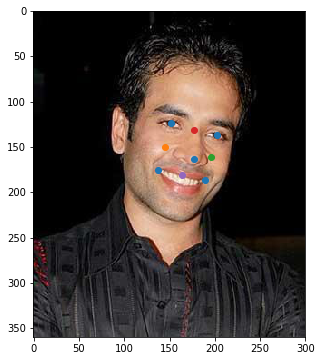

Top-bottom 0.61948204 left right 1.8960658
(360, 300, 3)
[[152. 124.]
 [202. 137.]
 [177. 163.]
 [137. 175.]
 [189. 186.]]
shrink


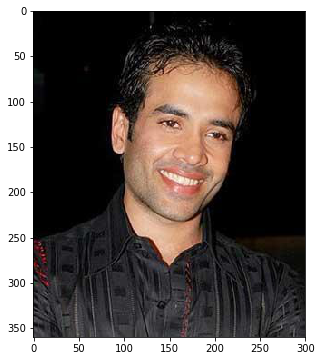

crop


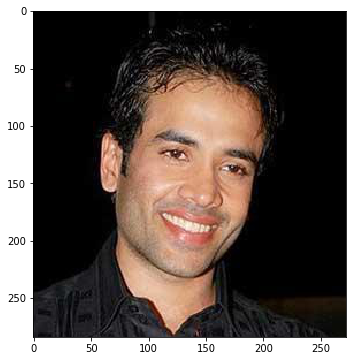

superres


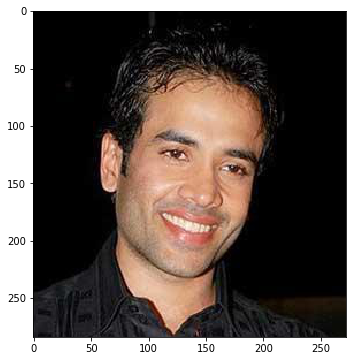

pad
(408, 396, 3)


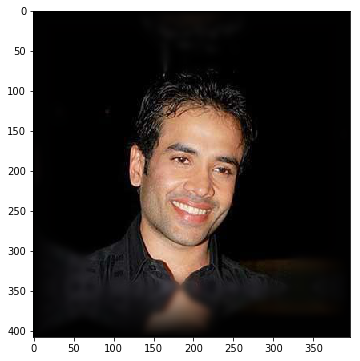

transform


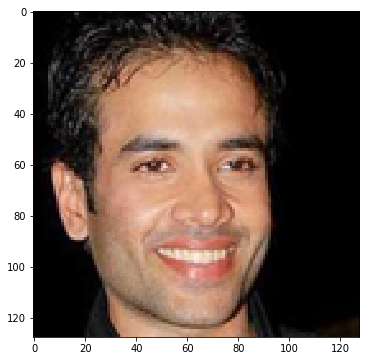

In [17]:
ex = 80
_= ds.process_img(data[ex], landmarks[ex], verbose=True)

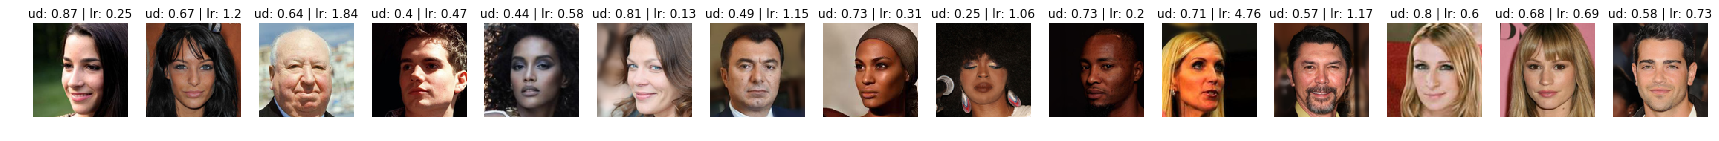

In [18]:
imsize = 2; nex = 15
fig, ax = plt.subplots(nrows=1,ncols=nex, figsize=(imsize*nex,imsize))
for i,idx in enumerate(tqdm(np.random.randint(0,len(data), nex))):
    img,  up_down, left_right = ds.process_img(data[idx], landmarks[idx], verbose=False)
    ax[i].imshow(np.reshape(img/255., (dim,dim,3)), interpolation='nearest'); ax[i].axis('off')
    ax[i].set_title('ud: '+str(round(up_down,2)) +' | lr: '+ str(round(left_right,2)))
plt.show()

#### Create CelebA dataset

In [19]:
# mini dataset
#data=data[-1000:]
#attrs_body = attrs_body[-1000:]
#landmarks= landmarks[-1000:]

In [20]:
n_jobs = 15 # adjust this based on how many threads you can use
chunk_size = n_jobs*20 # adjust this based on how much memory you have available

In [21]:
chunk_size

300

In [22]:
np.shape(data), np.shape(attrs_body)

((202599,), (202599, 40))

In [23]:
size = 128

In [24]:
path = 'data/CELEBA-'+str(size)+'-Annot.h5'

In [25]:
with Parallel(n_jobs=n_jobs, verbose=0) as parallel:
    with h5py.File(path, 'w') as f:
        # prepare dataaset
        dset_label_input = f.create_dataset('attrs_head', data = np.string_(attrs_head + ['left_right', 'up_down']))
        
        dset = f.create_dataset('images', (chunk_size,dim*dim*3), maxshape=(None,dim*dim*3),
                                dtype='i8', chunks=(chunk_size,dim*dim*3))
        
        dset_attrs = f.create_dataset('attrs', (chunk_size,42), maxshape=(None,42),
                                dtype='float32', chunks=(chunk_size,42))
        
   
        # set first chunk
        imgs, up_down, left_right  = np.array(parallel(delayed(ds.process_img)(path, lm, size = size) for index, (path, lm) in enumerate(tqdm(zip(data[:chunk_size],
                                                                                                                 landmarks[:chunk_size]), leave=False)))).T
        dset[:] = np.stack(imgs)
        dset_attrs[:] = np.hstack([attrs_body[:chunk_size], np.vstack(left_right), np.vstack(up_down)])
        # add flipped images
        dset.resize(dset.shape[0]+chunk_size, axis=0)
        dset[-chunk_size:] = np.flip(np.stack(imgs).reshape((len(imgs), size, size, 3)), axis = 2).reshape(np.shape(np.stack(imgs)))
        dset_attrs.resize(dset_attrs.shape[0]+chunk_size, axis=0)
        dset_attrs[-chunk_size:] = np.hstack([attrs_body[:chunk_size], 1./np.vstack(left_right), np.vstack(up_down)])
        
        for chunk in tqdm(np.arange(1,np.floor(len(data) / chunk_size).astype('int'))):
            dset.resize(dset.shape[0]+chunk_size, axis=0)
            dset_attrs.resize(dset_attrs.shape[0]+chunk_size, axis=0)
            imgs, up_down, left_right = np.array(parallel(delayed(ds.process_img)(path, lm, size = size) for index, (path, lm) in 
                                                   enumerate(tqdm(zip(data[chunk_size*chunk:chunk_size*(chunk+1)],
                                                                      landmarks[chunk_size*chunk:chunk_size*(chunk+1)]), leave=False)))).T
            dset[-chunk_size:] = np.stack(imgs)
            dset_attrs[-chunk_size:] = np.hstack([attrs_body[chunk_size*chunk:chunk_size*(chunk+1)], np.vstack(left_right), np.vstack(up_down)])
            
            dset.resize(dset.shape[0]+chunk_size, axis=0)
            dset[-chunk_size:] = np.flip(np.stack(imgs).reshape((len(imgs), size, size, 3)), axis = 2).reshape(np.shape(np.stack(imgs)))
            dset_attrs.resize(dset_attrs.shape[0]+chunk_size, axis=0)
            dset_attrs[-chunk_size:] = np.hstack([attrs_body[chunk_size*chunk:chunk_size*(chunk+1)], 1./np.vstack(left_right), np.vstack(up_down)])
            

/mnt/cube/tsainbur/Projects/github_repos/GAIA-simple/dataset.py:58: RuntimeWarning: divide by zero encountered in float_scalars
  left_right = left_to_nose/right_to_nose


/mnt/cube/tsainbur/Projects/github_repos/GAIA-simple/dataset.py:58: RuntimeWarning: divide by zero encountered in float_scalars
  left_right = left_to_nose/right_to_nose


/mnt/cube/tsainbur/conda_envs/txori_py3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in true_divide


/mnt/cube/tsainbur/Projects/github_repos/GAIA-simple/dataset.py:58: RuntimeWarning: divide by zero encountered in float_scalars
  left_right = left_to_nose/right_to_nose


/mnt/cube/tsainbur/Projects/github_repos/GAIA-simple/dataset.py:58: RuntimeWarning: divide by zero encountered in float_scalars
  left_right = left_to_nose/right_to_nose


/mnt/cube/tsainbur/Projects/github_repos/GAIA-simple/dataset.py:58: RuntimeWarning: divide by zero encountered in float_scalars
  left_right = left_to_nose/right_to_nose


/mnt/cube/tsainbur/Projects/github_repos/GAIA-simple/dataset.py:58: RuntimeWarning: divide by zero encountered in float_scalars
  left_right = left_to_nose/right_to_nose


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.




Traceback (most recent call last):
  File "/mnt/cube/tsainbur/conda_envs/txori_py3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-25-d6c25bc5e99b>", line 29, in <module>
    landmarks[chunk_size*chunk:chunk_size*(chunk+1)]), leave=False)))).T
  File "/mnt/cube/tsainbur/conda_envs/txori_py3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py", line 789, in __call__
    self.retrieve()
  File "/mnt/cube/tsainbur/conda_envs/txori_py3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py", line 699, in retrieve
    self._output.extend(job.get(timeout=self.timeout))
  File "/mnt/cube/tsainbur/conda_envs/txori_py3/lib/python3.6/multiprocessing/pool.py", line 638, in get
    self.wait(timeout)
  File "/mnt/cube/tsainbur/conda_envs/txori_py3/lib/python3.6/multiprocessing/pool.py", line 635, in wait
    self._event.wait(timeout)
  File "/mnt/cube/tsainbur/

KeyboardInterrupt: 

### Test read a face

In [26]:
with h5py.File(path, 'r') as hf:
    face = hf['images'][1]
    print(len(hf['images']))

239100


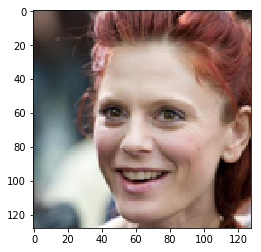

In [27]:
plt.imshow(face.reshape((dim,dim,3)))

In [28]:
with h5py.File(path, 'r') as hf:
    faces = hf['images'][:200]

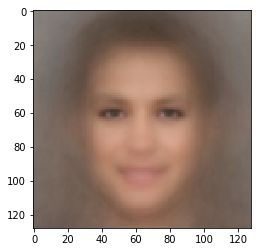

In [29]:
plt.imshow(np.reshape(np.mean(faces, axis = 0)/255, (dim,dim,3)))

In [30]:
nx = 5
ny = 15
canvas = np.zeros((dim*nx,dim*ny,3), dtype='uint8')
for x in np.arange(nx):
    for y in np.arange(ny):
        canvas[x*dim:(x+1)*dim,y*dim:(y+1)*dim,:] = faces[x*ny+y].reshape((dim,dim,3))

(-0.5, 1919.5, 639.5, -0.5)

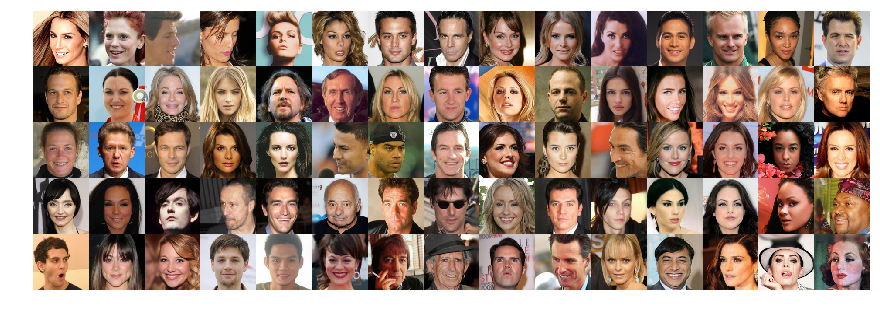

In [31]:
z =3
fig, ax = plt.subplots(figsize=(nx*z, ny*z))
ax.imshow(canvas)
ax.axis('off')

### Test read attributes

In [32]:
ex = 900
with h5py.File(path, 'r') as hf:
    print(len(hf['images']))
    face = hf['images'][ex]
    attrs = hf['attrs'][ex]
    print(list(hf.keys()))

239100
['attrs', 'attrs_head', 'images']


In [33]:
print(' | '.join([str(i)+' '+j for i,j in enumerate(attrs_head)]))

0 5_o_Clock_Shadow | 1 Arched_Eyebrows | 2 Attractive | 3 Bags_Under_Eyes | 4 Bald | 5 Bangs | 6 Big_Lips | 7 Big_Nose | 8 Black_Hair | 9 Blond_Hair | 10 Blurry | 11 Brown_Hair | 12 Bushy_Eyebrows | 13 Chubby | 14 Double_Chin | 15 Eyeglasses | 16 Goatee | 17 Gray_Hair | 18 Heavy_Makeup | 19 High_Cheekbones | 20 Male | 21 Mouth_Slightly_Open | 22 Mustache | 23 Narrow_Eyes | 24 No_Beard | 25 Oval_Face | 26 Pale_Skin | 27 Pointy_Nose | 28 Receding_Hairline | 29 Rosy_Cheeks | 30 Sideburns | 31 Smiling | 32 Straight_Hair | 33 Wavy_Hair | 34 Wearing_Earrings | 35 Wearing_Hat | 36 Wearing_Lipstick | 37 Wearing_Necklace | 38 Wearing_Necktie | 39 Young


['Attractive' 'Brown_Hair' 'Heavy_Makeup' 'High_Cheekbones'
 'Mouth_Slightly_Open' 'No_Beard' 'Oval_Face' 'Pointy_Nose' 'Smiling'
 'Wearing_Earrings' 'Wearing_Lipstick']


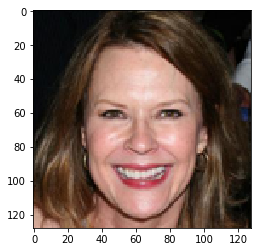

In [34]:
plt.imshow(face.reshape((dim,dim,3)))
print(np.array(attrs_head)[attrs[:40]==1])

In [35]:
with h5py.File(path, 'r') as hf:
    face = hf['images'][-1000:]
    attrs = hf['attrs'][-1000:]
    print(list(hf.keys()))

['attrs', 'attrs_head', 'images']


In [36]:
attr_num = 9
attrs_head[attr_num]

'Blond_Hair'

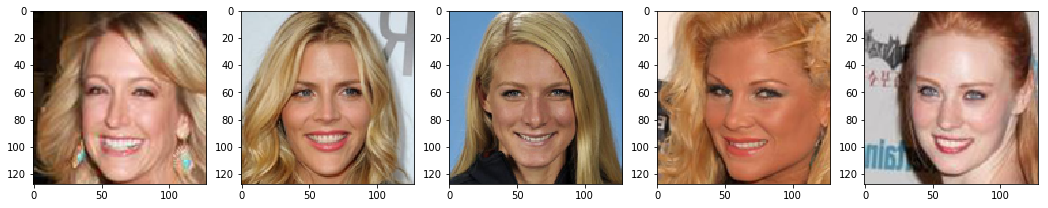

In [37]:
zoom = 3
fig, ax = plt.subplots(nrows=1,ncols=5, figsize=(6*zoom,6*5*zoom))
for i,face_i in enumerate(face[attrs[:,attr_num]==1][-5:]):
    ax[i].imshow(face_i.reshape((dim,dim,3)))

### Test face direction attribute

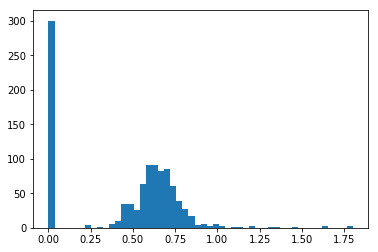

In [39]:
#_= plt.hist(np.log(attrs[:,-1]), bins = 50)
_= plt.hist(attrs[:,-1], bins = 50)

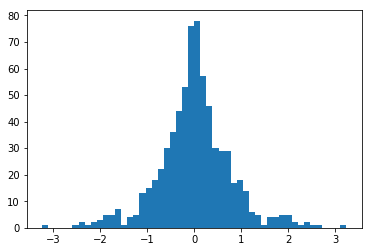

In [45]:
_= plt.hist(np.log(attrs[:,-2][attrs[:,-2] !=0]), bins = 50)
#_= plt.hist(attrs[:,-2], bins = 50)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

/mnt/cube/tsainbur/conda_envs/txori_py3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


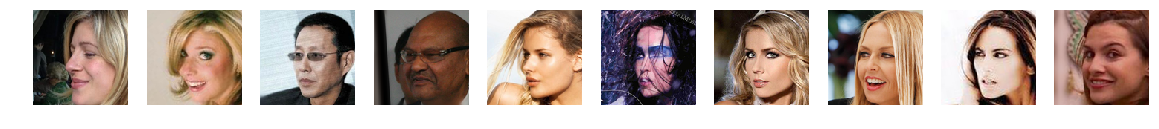

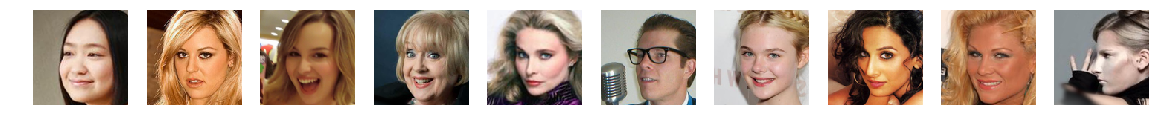

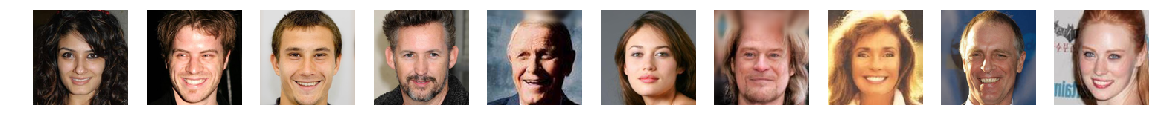

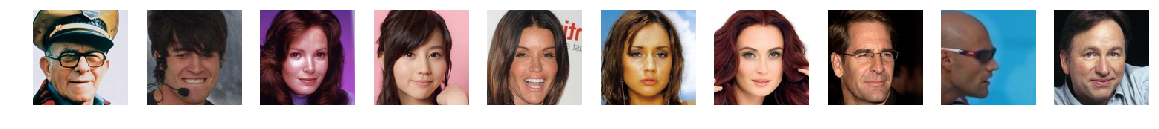

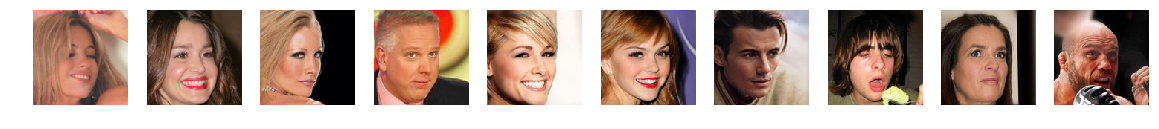

In [46]:
# left right
zoom = 2
nex = 10
for dirup,dirdown in zip(np.linspace(-2.5,2.5,7)[1:], np.linspace(-2,2,6)[:-1]):
    fig, ax = plt.subplots(nrows=1,ncols=nex, figsize=(zoom*nex,zoom))
    f = face[(np.log(attrs[:,-2]) < dirup) & (np.log(attrs[:,-2]) > dirdown)][-nex:]
    for i in range(len(f)): ax[i].imshow(f[i].reshape((dim,dim,3))); ax[i].axis('off')
    plt.show()

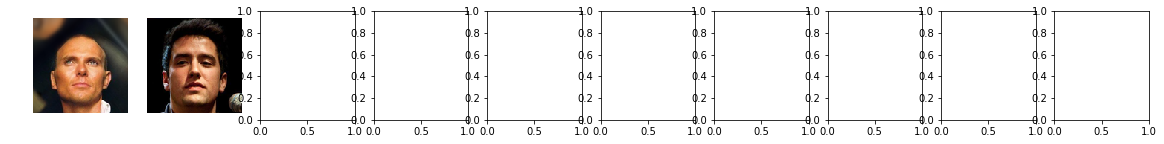

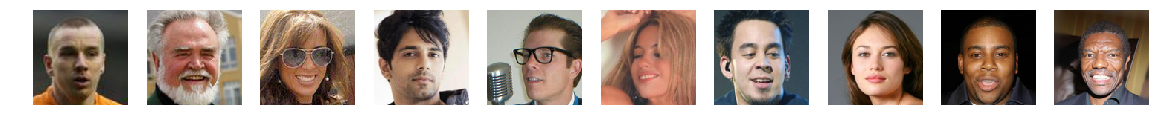

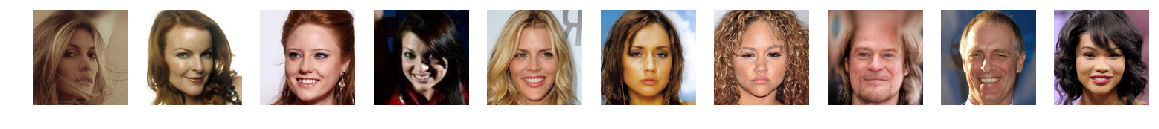

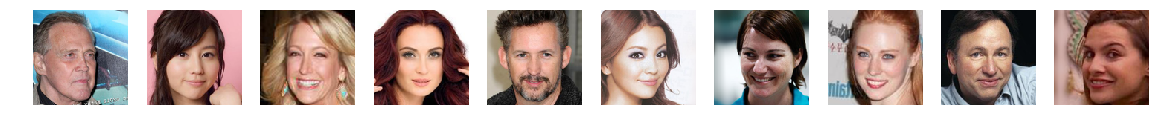

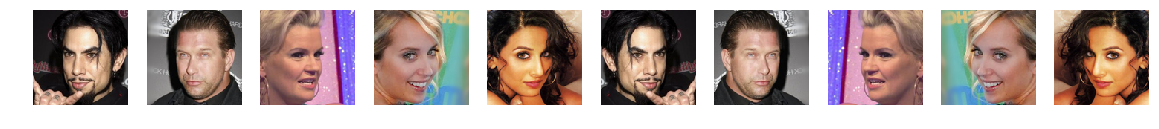

In [51]:
# up down 
zoom = 2
nex = 10
for dirup,dirdown in zip(np.linspace(.25,1,7)[1:], np.linspace(.25,1,6)[:-1]):
    fig, ax = plt.subplots(nrows=1,ncols=nex, figsize=(zoom*nex,zoom))
    f = face[((attrs[:,-1]) < dirup) & ((attrs[:,-1]) > dirdown)][-nex:]
    for i in range(len(f)): ax[i].imshow(f[i].reshape((dim,dim,3))); ax[i].axis('off')
    plt.show()